In [25]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# Some constants 
#INPUT_FOLDER = r'C:\\Users\Rajeev Ranjan\Desktop\Fall 2018\CS598JP\New folder\data'
#patients = os.listdir(INPUT_FOLDER)
#patients.sort()


In [97]:
path  = r'C:\Users\Rajeev Ranjan\Desktop\Fall 2018\CS598JP\Data\data\LIDC-IDRI-0002\01-01-2000-98329\3000522-04919'

In [98]:
slices = [dicom.read_file(path + '/' + s, force=True ) for s in os.listdir(path)]
#print(slices[0])
#print(slices[0].ImagePositionPatient)

def lean_(slices):
    slices_ = []
    for num,s in enumerate(slices) :
        try:
            s.ImagePositionPatient[2]
            slices_.append(s) 
        except:
            
            continue
    return slices_


In [99]:
len(slices)

262

In [100]:
# Load the scans in given folder path
def load_scan(path):
    slices = lean_([dicom.read_file(path + '/' + s, force=True ) for s in os.listdir(path)])
    #Z position of slices
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
        #print(slice_thickness)
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [101]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        #How to apply the rescale slope/intercept: final_value = original_value * rescale_slope + rescale_intercept
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)


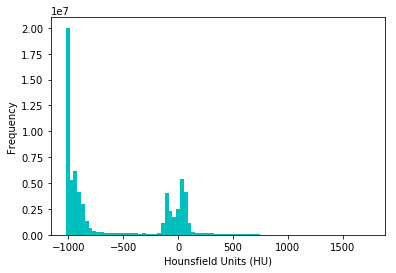

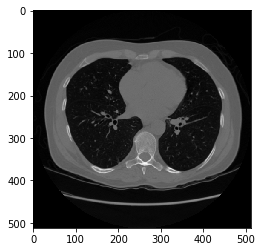

In [102]:
first_patient = load_scan(path)
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()
#### Plot images 
plt.imshow(first_patient_pixels[100], cmap=plt.cm.gray) #133 slices
plt.show()

In [54]:
def resample(image, scan, new_spacing=[1,1,1]):
    """
    Output - Numpy array 
    
    """
    print("Entering resample function ...")
    # Determine current pixel spacing
    
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)
    print(spacing)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [103]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Entering resample function ...
[1.25     0.681641 0.681641]
Shape before resampling	 (261, 512, 512)
Shape after resampling	 (326, 349, 349)


In [55]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes_classic(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()


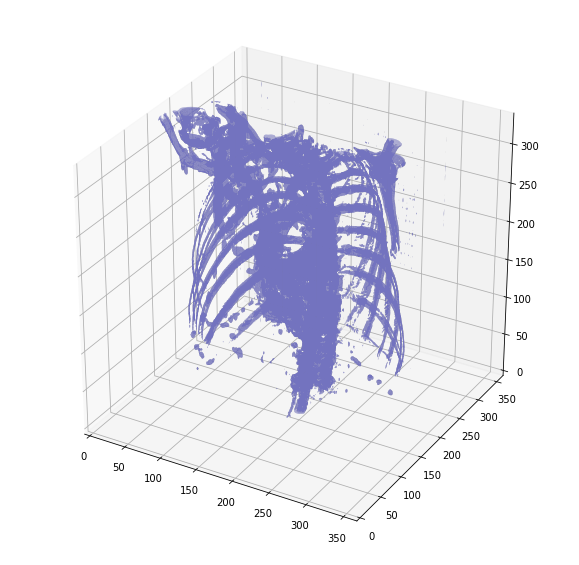

In [56]:
plot_3d(pix_resampled, 400)


### Lung Segementation

In [107]:

def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    biggest = vals[np.argmax(counts)]
    return biggest

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    
    #Label connected regions of an integer array.
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    # Background lable is the air, picked for every CT SCAN 
    background_label = labels[0,0,0] #1

    #Fill the air around the person - Using the connected components generated 
    binary_image[background_label == labels] = 2
    #print(labels[0,0,0])
    #print(binary_image[0])
    # Method of filling the lung structures 
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

In [115]:
import cv2

diff = (segmented_lungs_fill - segmented_lungs).astype(np.uint8)
kernel = np.ones((5,5),np.uint8)
dilated_one = cv2.dilate(diff,kernel,iterations = 1)


In [124]:
def plot_comparison(original, dilated_one[100], filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

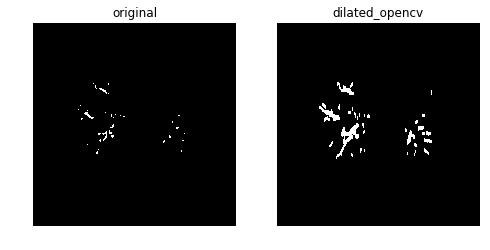

In [125]:
plot_comparison(diff[100],dilated_one[100],"dilated_opencv")

In [123]:
# Dilation enlarges bright regions

from skimage.morphology import disk
dilated_ski = disk(diff)
plt.imshow(dilated_ski[100], cmap=plt.cm.gray) #133 slices
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [117]:
dilated_one.shape

(326, 349, 349)

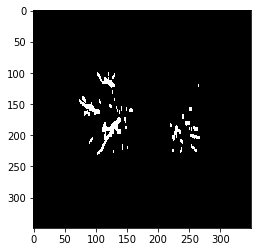

In [119]:
plt.imshow(dilated_one[100], cmap=plt.cm.gray) #133 slices
plt.show()

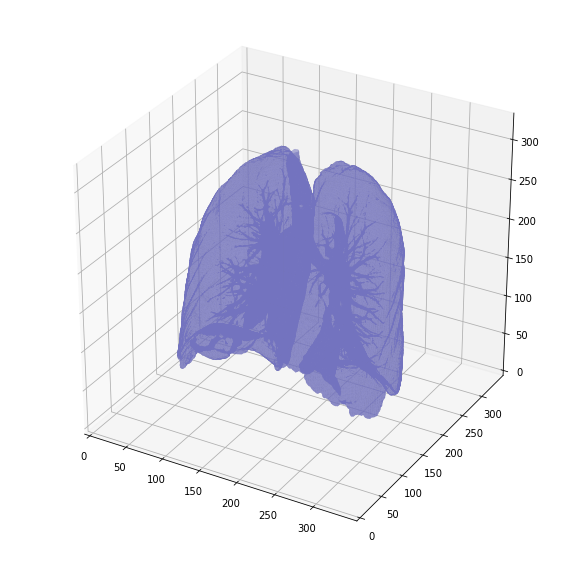

In [108]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)
#plot_3d(segmented_lungs, 0)

In [111]:
skimage.morphology.disk(radius, dtype=<class 'numpy.uint8'>)

  Could not find a version that satisfies the requirement cv2 (from versions: )
No matching distribution found for cv2
You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


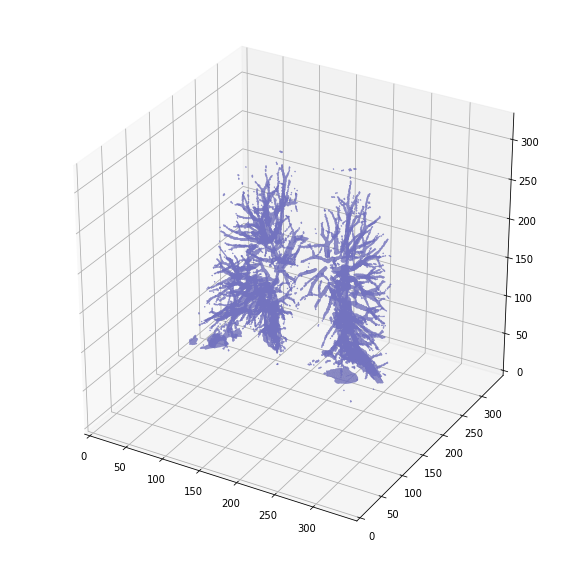

In [109]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)


In [ ]:
#### Method 2

In [71]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import dicom
import scipy.misc

In [72]:
def get_segmented_lungs(im, plot=False):
    
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(8, 1, figsize=(5, 40))
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < 604
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone) 
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.bone) 
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot == True:
        plots[7].axis('off')
        plots[7].imshow(im, cmap=plt.cm.bone) 
        
    return im

TypeError: '<' not supported between instances of 'FileDataset' and 'int'

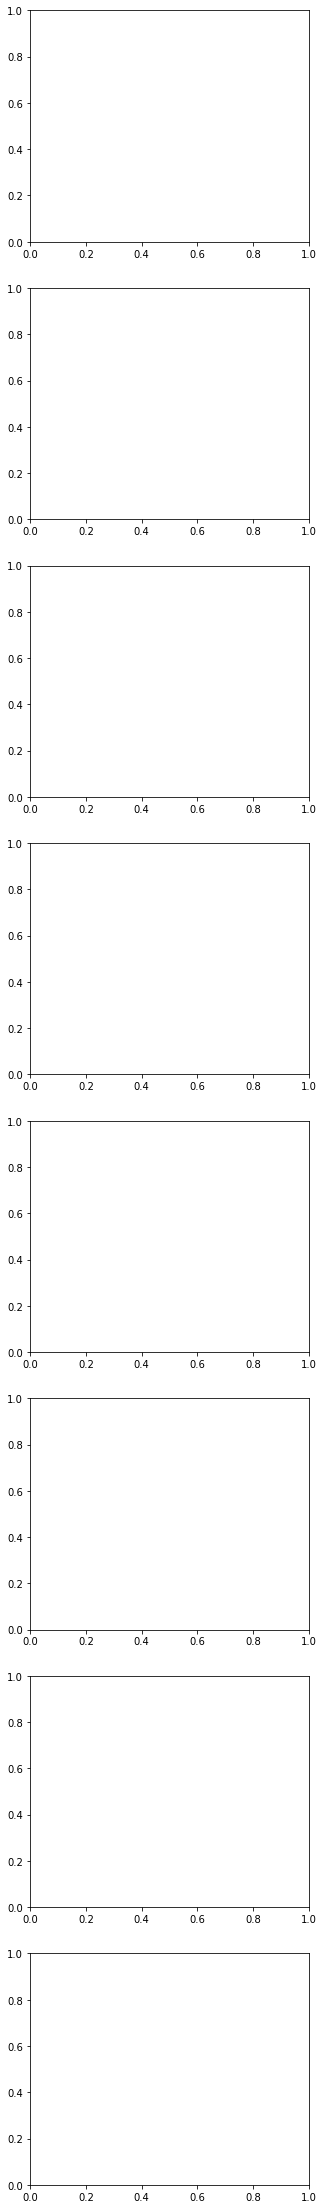

In [75]:
get_segmented_lungs(first_patient_pixels[0], True)


## PART 2

In [15]:
from optparse import OptionParser
import numpy as np
import os
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
from keras.models import Model
from skimage import measure, morphology, segmentation
from keras.utils import np_utils
import cv2
import scipy.ndimage
import dicom
from keras.models import model_from_json
import tensorflow as tf
from scipy.ndimage.interpolation import rotate

def load_scan(path):
    print("Entering load_scan function ...")
    
    slices = lean_([dicom.read_file(path + '/' + s, force=True ) for s in os.listdir(path)])
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def get_pixels_hu(slices):
    print("Entering get_pixels_hu function ...")
    
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    #image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    image[image <= -1024] = -1024
    
    return np.array(image, dtype=np.int16)

def resample(image, scan, new_spacing=[1,1,1]):
    print("Entering resample function ...")
    
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None


def getSegmentedPatient(patient):
    print("Entering getSegmentedPatient function ...")
    
    x = load_scan(patient)
    first_patient_pixels = get_pixels_hu(x)
    pix_resampled, spacing = resample(first_patient_pixels, x, [1,1,1])
    segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

    kernel = np.ones((5,5),np.uint8)

    for slicen in range(pix_resampled.shape[0]):
        tmp = segmented_lungs_fill[slicen,:,:].copy()
        tmp = cv2.erode(tmp.astype('int16'),kernel,iterations = 1)
        tmp = cv2.dilate(tmp.astype('int16'),kernel,iterations = 3)
        pix_resampled[slicen,:,:][tmp == 0] = -1024
        
    return pix_resampled

    


In [16]:
def getCube(img_array, model):
    n_size = 64
    
    img_array = img_array.astype('float32')
    img_array += 1024
    img_array[img_array < 0] = 0
    img_array /= 1500
    img_array[img_array > 1] = 1
    
    img_array = rotate(img_array, 90)
    
    zz = []
    zz5 = []
    
    cpt = 0
    for x in range(0, img_array.shape[0]-n_size, int(n_size/8)):
        print
        for y in range(0, img_array.shape[1]-n_size, int(n_size/8 )):
            for z in range(0, img_array.shape[2]-n_size,int( n_size/8)):
                crop = img_array[x:x+n_size, y:y+n_size, z:z+n_size].copy()
                if np.mean(crop) < 0.05:
                    continue
                zz.append(np.expand_dims(crop, axis=0))
                cpt += 1
                
                
                if cpt % 500 == 0:
                    oo = np.concatenate((zz))
                    print(cpt)
                    if type(oo) == list:
                        continue
                    oo = oo.reshape(oo.shape[0], 64, 64, 64, 1)
                    with tf.device('/cpu:0'):
                        mm = model.predict(oo, batch_size=5)
                        print("ebueueb")
                        zz5.append(np.expand_dims(np.max(mm, axis=0), axis=0))
                    zz = []
                    
                    
    
    oo = np.concatenate((zz))

    if type(oo) != list:
        oo = oo.reshape(oo.shape[0], 64, 64, 64, 1)
        with tf.device('/cpu:0'):
            mm = model.predict(oo, batch_size=5)
            zz5.append(np.expand_dims(np.max(mm, axis=0), axis=0))
            
    cc = np.concatenate((zz5))
    if type(cc) == list:
        return []
    
    return np.max(cc, axis=0)

In [17]:

def init_model():
    with tf.device('/cpu:0'):
        config = tf.ConfigProto()
        config.gpu_options.per_process_gpu_memory_fraction = 0.1
        session = tf.Session(config=config)
    
        json_file = open('model64x64x64_v5_rotate_v2.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)
        # load weights into new model
        model.load_weights("model64x64x64_v5_rotate_v2.h5")
        print("Loaded model from disk")
        
        model2 = Model(input=model.input, output=model.get_layer('flatten_3').output)
        
        return model2

In [18]:
def lean_(slices):
    slices_ = []
    for s in slices :
        try:
            s.ImagePositionPatient[2]
            slices_.append(s) 
        except:
            continue
    return slices_

In [20]:
def segment_lung_mask(image, fill_lung_structures=True):
    print("Entering segment_lung_mask function ...")
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image, neighbors=4)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    
    return binary_image

In [21]:
model = init_model()
    
z_fin_id = []
z_fin_feature = []

cpt = 0
#for i in os.listdir(opts.input_dir):
#cpt += 1
path  = r'C:\Users\Rajeev Ranjan\Desktop\Fall 2018\CS598JP\New folder\data\LIDC-IDRI-0001\01-01-2000-30178\3000566-03192'
print("Processing ID patient")

pix_resampled = getSegmentedPatient(path)
zz = getCube(pix_resampled, model)


z_fin_feature.append(zz)
z_fin_id.append(i)
    

Loaded model from disk
Processing ID patient
Entering getSegmentedPatient function ...
Entering load_scan function ...


c:\anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("ba..., outputs=Tensor("fl...)`
  app.launch_new_instance()


Entering get_pixels_hu function ...
Entering resample function ...
Entering segment_lung_mask function ...
500


KeyboardInterrupt: 

### Test

In [35]:
from optparse import OptionParser
import numpy as np
import os
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
import scipy.ndimage
import dicom
import pickle


def getXGBPrediction(X_test, gbm):
    
    dtest = xgb.DMatrix(X_test, missing=np.nan)
    return gbm.predict(dtest)


def get_sje_df(opts):
    sje_features = np.load(opts.input_unet_model)['arr_0'][()]

    cpt = 0
    for i in sorted(sje_features):
        if cpt == 0:
            df_sje = pd.DataFrame(sje_features[i], 
                                  columns=['S' + str(cpt) + '_' + str(j) for j in range(sje_features[i].shape[1])])
        elif i == 'ids':
            df_sje['id'] = [os.path.basename(j) for j in sje_features[i]]
        else:
            df_sje = pd.concat([df_sje, 
                                pd.DataFrame(sje_features[i], columns=['S' + str(cpt) + '_' + str(j) for j in range(sje_features[i].shape[1])])], axis=1)
        cpt += 1

    return df_sje
